# Grid2dLSTM 构建高抽象的多因子股票时间序列预测模型

## 1前置假设

这里假设股票市场的对数收益率在泛泛的情况下假想为一个弱平稳时间序列。

- **Stacked LSTM** Stacked LSTM通过堆砌多层LSTM的抽取下层LSTM的hidden_state的信息获得实例训练算法，这个取得了很好的效果提升，但是受限于tanh，这里使用的LSTM模型在超过5层之后的需要消耗的计算资源过大。我这里使用一个3层的Stacked LSTM模型进行。

- **Grid2dLSTM** Grid LSTM 是吸收Stacked LSTM和Multidimensional LSTM两种LSTM单元间网络结构形成的新算法设计。相对于Stacked结构，Grid2d使用维度概念代替Stacked里面的深度概念(层数)，将深度构建为另一个维度的序列，即转换多层LSTM为x，y维度的多维度LSTM网格结构。实验显示，Grid相对于Stacked效果有明显提升。由于计算资源有限，我只测试了3层Tied 和 3层No Tied的网络结构。



## 2数据对比

- 1 单层LSTM的样本外准确率为0.66
![](http://p1.bqimg.com/567571/17ad09fcc71075cf.png)

- 2 3层Stacked LSTM的样本外准确率为0.78
![](http://p1.bqimg.com/567571/00e47adebc75fea4.png)

- 3 层Grid2dLSTM样本外准确率约为为 0.7 (由于使用CPU这里模型迭代只进行了3000次，未达到最终收敛状态)
![](http://p1.bqimg.com/567571/956b362486577427.png)

  
- 3层Tied Grid2dLSTM模型的样本外准确率为 0.86 (由于使用CPU这里模型迭代只进行了3000次，未达到最终收敛状态)   
![](http://p1.bqimg.com/567571/3d763d30c1c395c3.png) 

- 6层Grid2dLSTM样本外准确率约为0.84(由于使用CPU这里模型迭代只进行了3000次，未达到最终收敛状态)   
![](http://i1.piimg.com/567571/8435bf42b4e6e5fc.png)

- 9层Grid2dLSTM样本外准确率约为0.85(由于使用CPU这里模型迭代只进行了3000次，未达到最终收敛状态)   
![](http://p1.bqimg.com/567571/687751086a9e9751.png)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import talib 
import datetime
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time

batch_size = 100
in_length = 59
in_width = 464
num_units = 128
num_dims = 2
outclasses = 3
learning_rate = 0.001
max_grad_norm = 5

- 代码开始写在本地，我在这里修改了时间格式为str匹配本地代码

In [2]:
start = '2013-01-01'
end = '2016-12-31'
frq = '15m'
tmp = get_price('603899.XSHG', start_date=start, end_date=end, frequency=frq)
tmp['Date'] = tmp.index.values
tmp.Date = pd.to_datetime(tmp.Date.values).strftime('%Y-%m-%d %H:%M:%S')
tmp.reset_index(inplace=True, drop=True)
tmp = tmp[['Date', 'total_turnover', 'volume', 'open', 'close', 'high', 'low']]

In [3]:
tmp.head()

,Date,total_turnover,volume,open,close,high,low
0,2015-01-27 09:45:00,545472.0,57600.0,9.2287,9.2287,9.2287,9.2287
1,2015-01-27 10:00:00,104170.0,11000.0,9.2287,9.2287,9.2287,9.2287
2,2015-01-27 10:15:00,115534.0,12200.0,9.2287,9.2287,9.2287,9.2287
3,2015-01-27 10:30:00,75760.0,8000.0,9.2287,9.2287,9.2287,9.2287
4,2015-01-27 10:45:00,75760.0,8000.0,9.2287,9.2287,9.2287,9.2287


In [4]:
tmp.to_csv('A1.csv')

In [5]:
start = '2013-01-01'
end = '2016-12-31'
frq = '1d'
Dtmp = get_price('603899.XSHG', start_date=start, end_date=end, frequency=frq)
Dtmp['Date'] = Dtmp.index.values
Dtmp.Date = pd.to_datetime(Dtmp.Date.values).strftime('%Y-%m-%d')
Dtmp.reset_index(inplace=True, drop=True)
Dtmp = Dtmp[['Date', 'open', 'close', 'high', 'low', 'total_turnover', 'volume','limit_up', 'limit_down']]

In [6]:
Dtmp.tail()

,Date,open,close,high,low,total_turnover,volume,limit_up,limit_down
467,2016-12-26,17.99,18.06,18.09,17.76,28621986.0,1599012.0,19.80,16.20
468,2016-12-27,18.05,17.98,18.08,17.88,29935947.0,1665444.0,19.87,16.25
469,2016-12-28,18.02,18.01,18.05,17.85,25430100.0,1416087.0,19.78,16.18
470,2016-12-29,17.89,17.96,18.04,17.86,14761397.0,822440.0,19.81,16.21
471,2016-12-30,18.02,18.20,18.37,17.96,38602505.0,2124742.0,19.76,16.16


In [7]:
Dtmp.to_csv('A2.csv')

In [8]:
tmp['oc'] = (tmp['close'] - tmp['open'])/tmp['open']
tmp['oh'] = (tmp['high'] - tmp['open'])/tmp['open']
tmp['ol'] = (tmp['low'] - tmp['open'])/tmp['open']
tmp['ch'] = (tmp['high'] - tmp['close'])/tmp['close']
tmp['cl'] = (tmp['low'] - tmp['close'])/tmp['close']
tmp['lh'] = (tmp['high'] - tmp['low'])/tmp['low']
tmp['oc_4'] = (tmp['close'] - tmp['open'].shift(4))/tmp['open'].shift(4)
tmp['oh_4'] = (tmp['high'] - tmp['open'].shift(4))/tmp['open'].shift(4)
tmp['ol_4'] = (tmp['low'] - tmp['open'].shift(4))/tmp['open'].shift(4)
tmp['co_8'] = (tmp['open'] - tmp['close'].shift(8))/tmp['close'].shift(8)
tmp['ch_8'] = (tmp['high'] - tmp['close'].shift(8))/tmp['close'].shift(8)
tmp['cl_8'] = (tmp['low'] - tmp['close'].shift(8))/tmp['close'].shift(8)
tmp['co_80'] = (tmp['open'] - tmp['close'].shift(80))/tmp['close'].shift(80)
tmp['ch_80'] = (tmp['high'] - tmp['close'].shift(80))/tmp['close'].shift(80)
tmp['cl_80'] = (tmp['low'] - tmp['close'].shift(80))/tmp['close'].shift(80)
tmp['ATR14'] = talib.ATR(tmp.high.values, tmp.low.values, tmp.close.values, timeperiod=14)
tmp['ATR6'] = talib.ATR(tmp.high.values, tmp.low.values, tmp.close.values, timeperiod=6)
tmp['EMA6'] = talib.EMA(tmp.close.values, timeperiod=6)
tmp['EMA12'] = talib.EMA(tmp.close.values, timeperiod=12)
tmp['EMA26'] = talib.EMA(tmp.close.values, timeperiod=26)
tmp['tEMA6'] = talib.EMA(tmp.total_turnover.values, timeperiod=6)
tmp['tEMA12'] = talib.EMA(tmp.total_turnover.values, timeperiod=12)
tmp['tEMA26'] = talib.EMA(tmp.total_turnover.values, timeperiod=26)
tmp['VEMA6'] = talib.EMA(tmp.volume.values, timeperiod=6)
tmp['VEMA12'] = talib.EMA(tmp.volume.values, timeperiod=12)
tmp['VEMA26'] = talib.EMA(tmp.volume.values, timeperiod=26)
tmp['MACD_DIF'], tmp['MACD_DEA'], tmp['MACD_bar'] = talib.MACD(
tmp.close.values, fastperiod=12, slowperiod=24, signalperiod=9)

In [9]:
faclist = ['oc', 'oh', 'ol', 'ch', 'cl', 'lh', 'oc_4', 'oh_4', 'ol_4', 'co_8',
       'ch_8', 'cl_8', 'co_80', 'ch_80', 'cl_80', 'ATR14', 'ATR6', 'EMA6',
       'EMA12', 'EMA26', 'tEMA6', 'tEMA12', 'tEMA26', 'VEMA6', 'VEMA12',
       'VEMA26', 'MACD_DIF', 'MACD_DEA', 'MACD_bar']
del_list = ['total_turnover', 'volume', 'open', 'close', 'high', 'low']

In [10]:
# 去极值
for i in faclist:
    mean = tmp.ix[:,i].mean()
    std = tmp.ix[:,i].std()
    tmp.loc[(tmp[i] > mean+3*std),i] = (mean + 3*std)

# 标准化
for i in faclist:
    mean = tmp.ix[:,i].mean()
    std = tmp.ix[:,i].std()
    tmp[i] = (tmp[i] - mean)/std

In [11]:
tmp.drop(labels=del_list, axis=1, inplace=True)
tmp.dropna(inplace= True)

Dtmp['returns'] = Dtmp.close.shift(-17)/Dtmp.close -1.
Dtmp.dropna(inplace=True)
Dtmp['dir_lab'] = 1
Dtmp.loc[Dtmp.returns>0.07,'dir_lab'] = 2 
Dtmp.loc[Dtmp.returns<-0.07,'dir_lab'] = 0 
Dtmp= Dtmp.iloc[-359:,:]
Dtmp.reset_index(drop= True , inplace= True)

start = Dtmp.Date.values[0]
end = Dtmp.Date.values[-1]
end = datetime.datetime.strptime(end, '%Y-%m-%d')
end = end + datetime.timedelta(days= 1)
end = end.strftime('%Y-%m-%d')

tmp = tmp.ix[(tmp.Date.values>start)&(tmp.Date.values<end)].reset_index(drop=True)
forward = 59
tmpfac = np.zeros((1, forward*16*29))
for i in np.arange(forward, int(len(Dtmp))):
    tp = tmp.iloc[16*(i-forward):16*i,1:]
    tp = np.array(tp).ravel(order='C').transpose()
    tmpfac = np.vstack((tmpfac, tp))
tmpfac = np.delete(tmpfac,0,axis=0)

trainX = tmpfac.reshape([-1,59,16*29])
trainY = (Dtmp.iloc[-300:,-1])

In [12]:
trainX.shape

(300, 59, 464)

In [13]:
trainY.shape

(300,)

In [14]:
def dense_to_one_hot(labels_dense):
    """标签 转换one hot 编码
    输入labels_dense 必须为非负数
    2016-11-21
    """
    num_classes = len(np.unique(labels_dense)) # np.unique 去掉重复函数
    raws_labels = labels_dense.shape[0]
    index_offset = np.arange(raws_labels) * num_classes
    labels_one_hot = np.zeros((raws_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot  

trainY = dense_to_one_hot(trainY)
trainY.shape

(300, 3)

In [15]:
testX = trainX[200:]
testY = trainY[200:]
trainX = trainX[:200]
trainY = trainY[:200]

In [16]:
tf.Graph().as_default()
tf.set_random_seed(20170305)

In [17]:
def LSTM(H_upper, H_lower, m, omega):
    H = tf.concat([H_upper, H_lower], axis=1)
    g_u = tf.sigmoid(tf.add(tf.matmul(a=H, b=omega['W_u']), omega['b_u']))
    g_f = tf.sigmoid(tf.add(tf.matmul(a=H, b=omega['W_f']), omega['b_f']))
    g_o = tf.sigmoid(tf.add(tf.matmul(a=H, b=omega['W_o']), omega['b_o']))
    g_c = tf.tanh(tf.add(tf.matmul(a=H, b=omega['W_c']), omega['b_c']))
    m_new = tf.add(tf.multiply(m,g_f), tf.multiply(g_c,g_u))
    h_new = tf.tanh(tf.multiply(m_new, g_o))
    return h_new, m_new 

def scan_Grid2dLSTM(initializer, elems):
    x_i = elems
    
    # layer 1
    I = initializer[0]
    h_1_A_prev = initializer[1]
    m_1_A_prev = initializer[2]
    m_1_B_prev = initializer[3]
    
    I_x_i = tf.matmul(x_i, I)
    h_1_A, m_1_A = LSTM(I_x_i, h_1_A_prev, m_1_A_prev, W_1_A)
    h_1_B, m_1_B = LSTM(I_x_i, h_1_A, m_1_B_prev, W_1_B)
    
    # layer 2
    h_2_A_prev = initializer[4]
    m_2_A_prev = initializer[5]
    
    h_2_A, m_2_A = LSTM(h_1_B, h_2_A_prev, m_2_A_prev, W_2_A)
    h_2_B, m_2_B = LSTM(h_1_B, h_2_A, m_1_B, W_2_B)
    
    # layer 3
    h_3_A_prev = initializer[6]
    m_3_A_prev = initializer[7]
    
    h_3_A, m_3_A = LSTM(h_2_B, h_3_A_prev, m_3_A_prev, W_3_A)
    h_3_B, m_3_B = LSTM(h_2_B, h_3_A, m_2_B, W_3_B)
    
    return (I, h_1_A, m_1_A, m_1_B, h_2_A, m_2_A, h_3_A, m_3_A, h_3_B)

In [18]:
W_1_A = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}

m_1_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))
h_1_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))
I = tf.Variable(tf.truncated_normal(shape=[in_width, num_units], dtype=tf.float32, name='a_projection_matrix'))


W_1_B = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}

m_1_B_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))

W_2_A = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}
m_2_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))
h_2_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))

W_2_B = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}

W_3_A = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}
m_3_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))
h_3_A_prev = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))

W_3_B = {
    'W_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),
    'W_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units*num_dims, num_units],dtype=tf.float32)),

    'b_u': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_f': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_o': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32)),
    'b_c': tf.Variable(initial_value=tf.truncated_normal(shape=[num_units], dtype=tf.float32))
}

output_init = tf.Variable(tf.zeros(shape=[batch_size, num_units], dtype=tf.float32))
init = (I, h_1_A_prev, m_1_A_prev, m_1_B_prev, h_2_A_prev, m_2_A_prev, h_3_A_prev, m_3_A_prev, output_init)

In [19]:
input_data = tf.placeholder(shape=[None, in_length, in_width], dtype=tf.float32)

X_input = tf.transpose(a=input_data, perm=[1,0,2])

targets = tf.placeholder(shape=[None,outclasses], dtype=tf.float32)

outputs = tf.scan(fn=scan_Grid2dLSTM, elems=X_input, initializer=init)[-1]

softmax_W = tf.Variable(tf.truncated_normal(shape=([num_units, outclasses]), dtype=tf.float32, name='softmax_W'))
softmax_b = tf.Variable(tf.truncated_normal(shape=([outclasses]), dtype=tf.float32, name='softmax_b'))
def matmul_deal(final_output):
    return tf.matmul(final_output, softmax_W) + softmax_b

final_output = tf.map_fn(matmul_deal, outputs)
final_output = tf.reverse(tensor=final_output, axis=[0])[0,:,:]

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=final_output, labels=targets))

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

params = tf.trainable_variables()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gvs = optimizer.compute_gradients(cost, params)
ysss = []
for i, (grid,var) in enumerate(gvs):
    if grid != None:
        grid = tf.clip_by_value(grid,-5.,5.)
        gvs[i] = (grid,var)
optimizer = optimizer.apply_gradients(gvs)

correct_pred = tf.equal(tf.argmax(final_output,1), tf.argmax(targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [20]:
%%time
loss_list = []
acc_list = []
acc_pred_list = []
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    for epoch in np.arange(100):
        for i in np.arange(int(len(trainX)/batch_size)):
            batch_x = trainX[i*batch_size: (i+1)*batch_size]
            batch_y = trainY[i*batch_size: (i+1)*batch_size]
            sess.run(optimizer, feed_dict={input_data:batch_x, targets:batch_y})
            acc, loss = sess.run([accuracy, cost], feed_dict={input_data:batch_x, targets:batch_y})    
            loss_list.append(loss)
            acc_list.append(acc)
        pred = sess.run(accuracy,feed_dict={input_data:testX, targets:testY})
        acc_pred_list.append(pred)

CPU times: user 23min 11s, sys: 54.9 s, total: 24min 6s
Wall time: 4min 56s


/srv/env/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


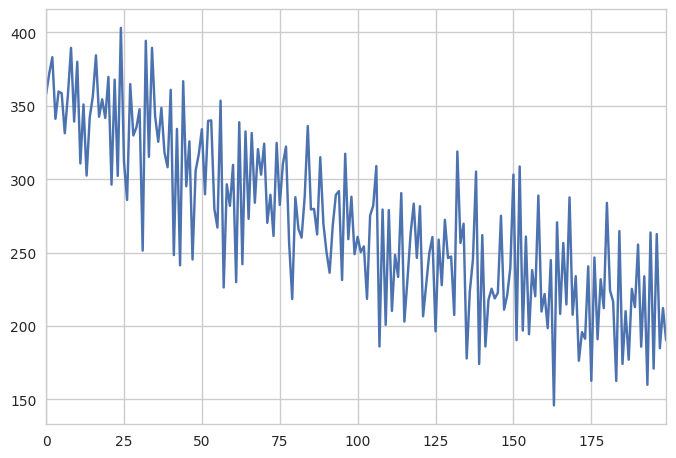

In [21]:
tmp = pd.Series(loss_list)
tmp.plot()

/srv/env/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


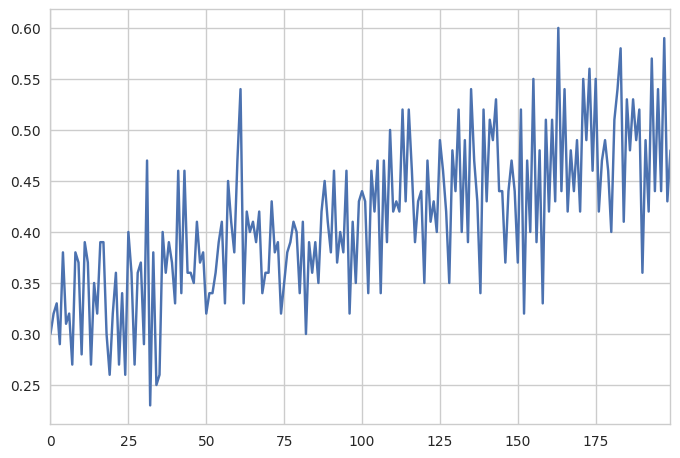

In [22]:
tmp = pd.Series(acc_list)
tmp.plot()

/srv/env/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


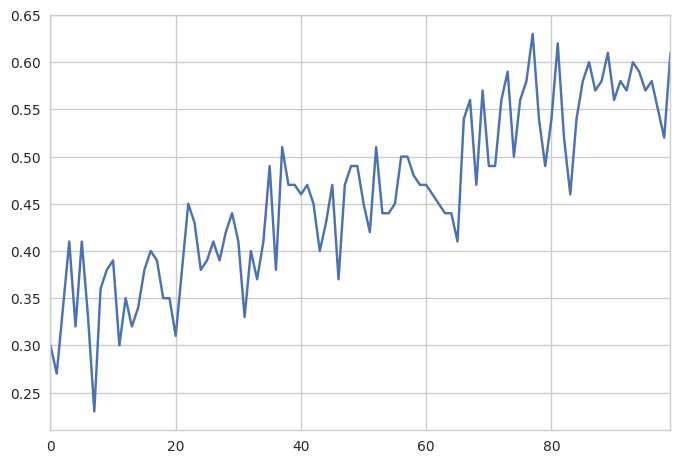

In [23]:
tmp = pd.Series(acc_pred_list)
tmp.plot()